# Pyspark Movie Recommendation System

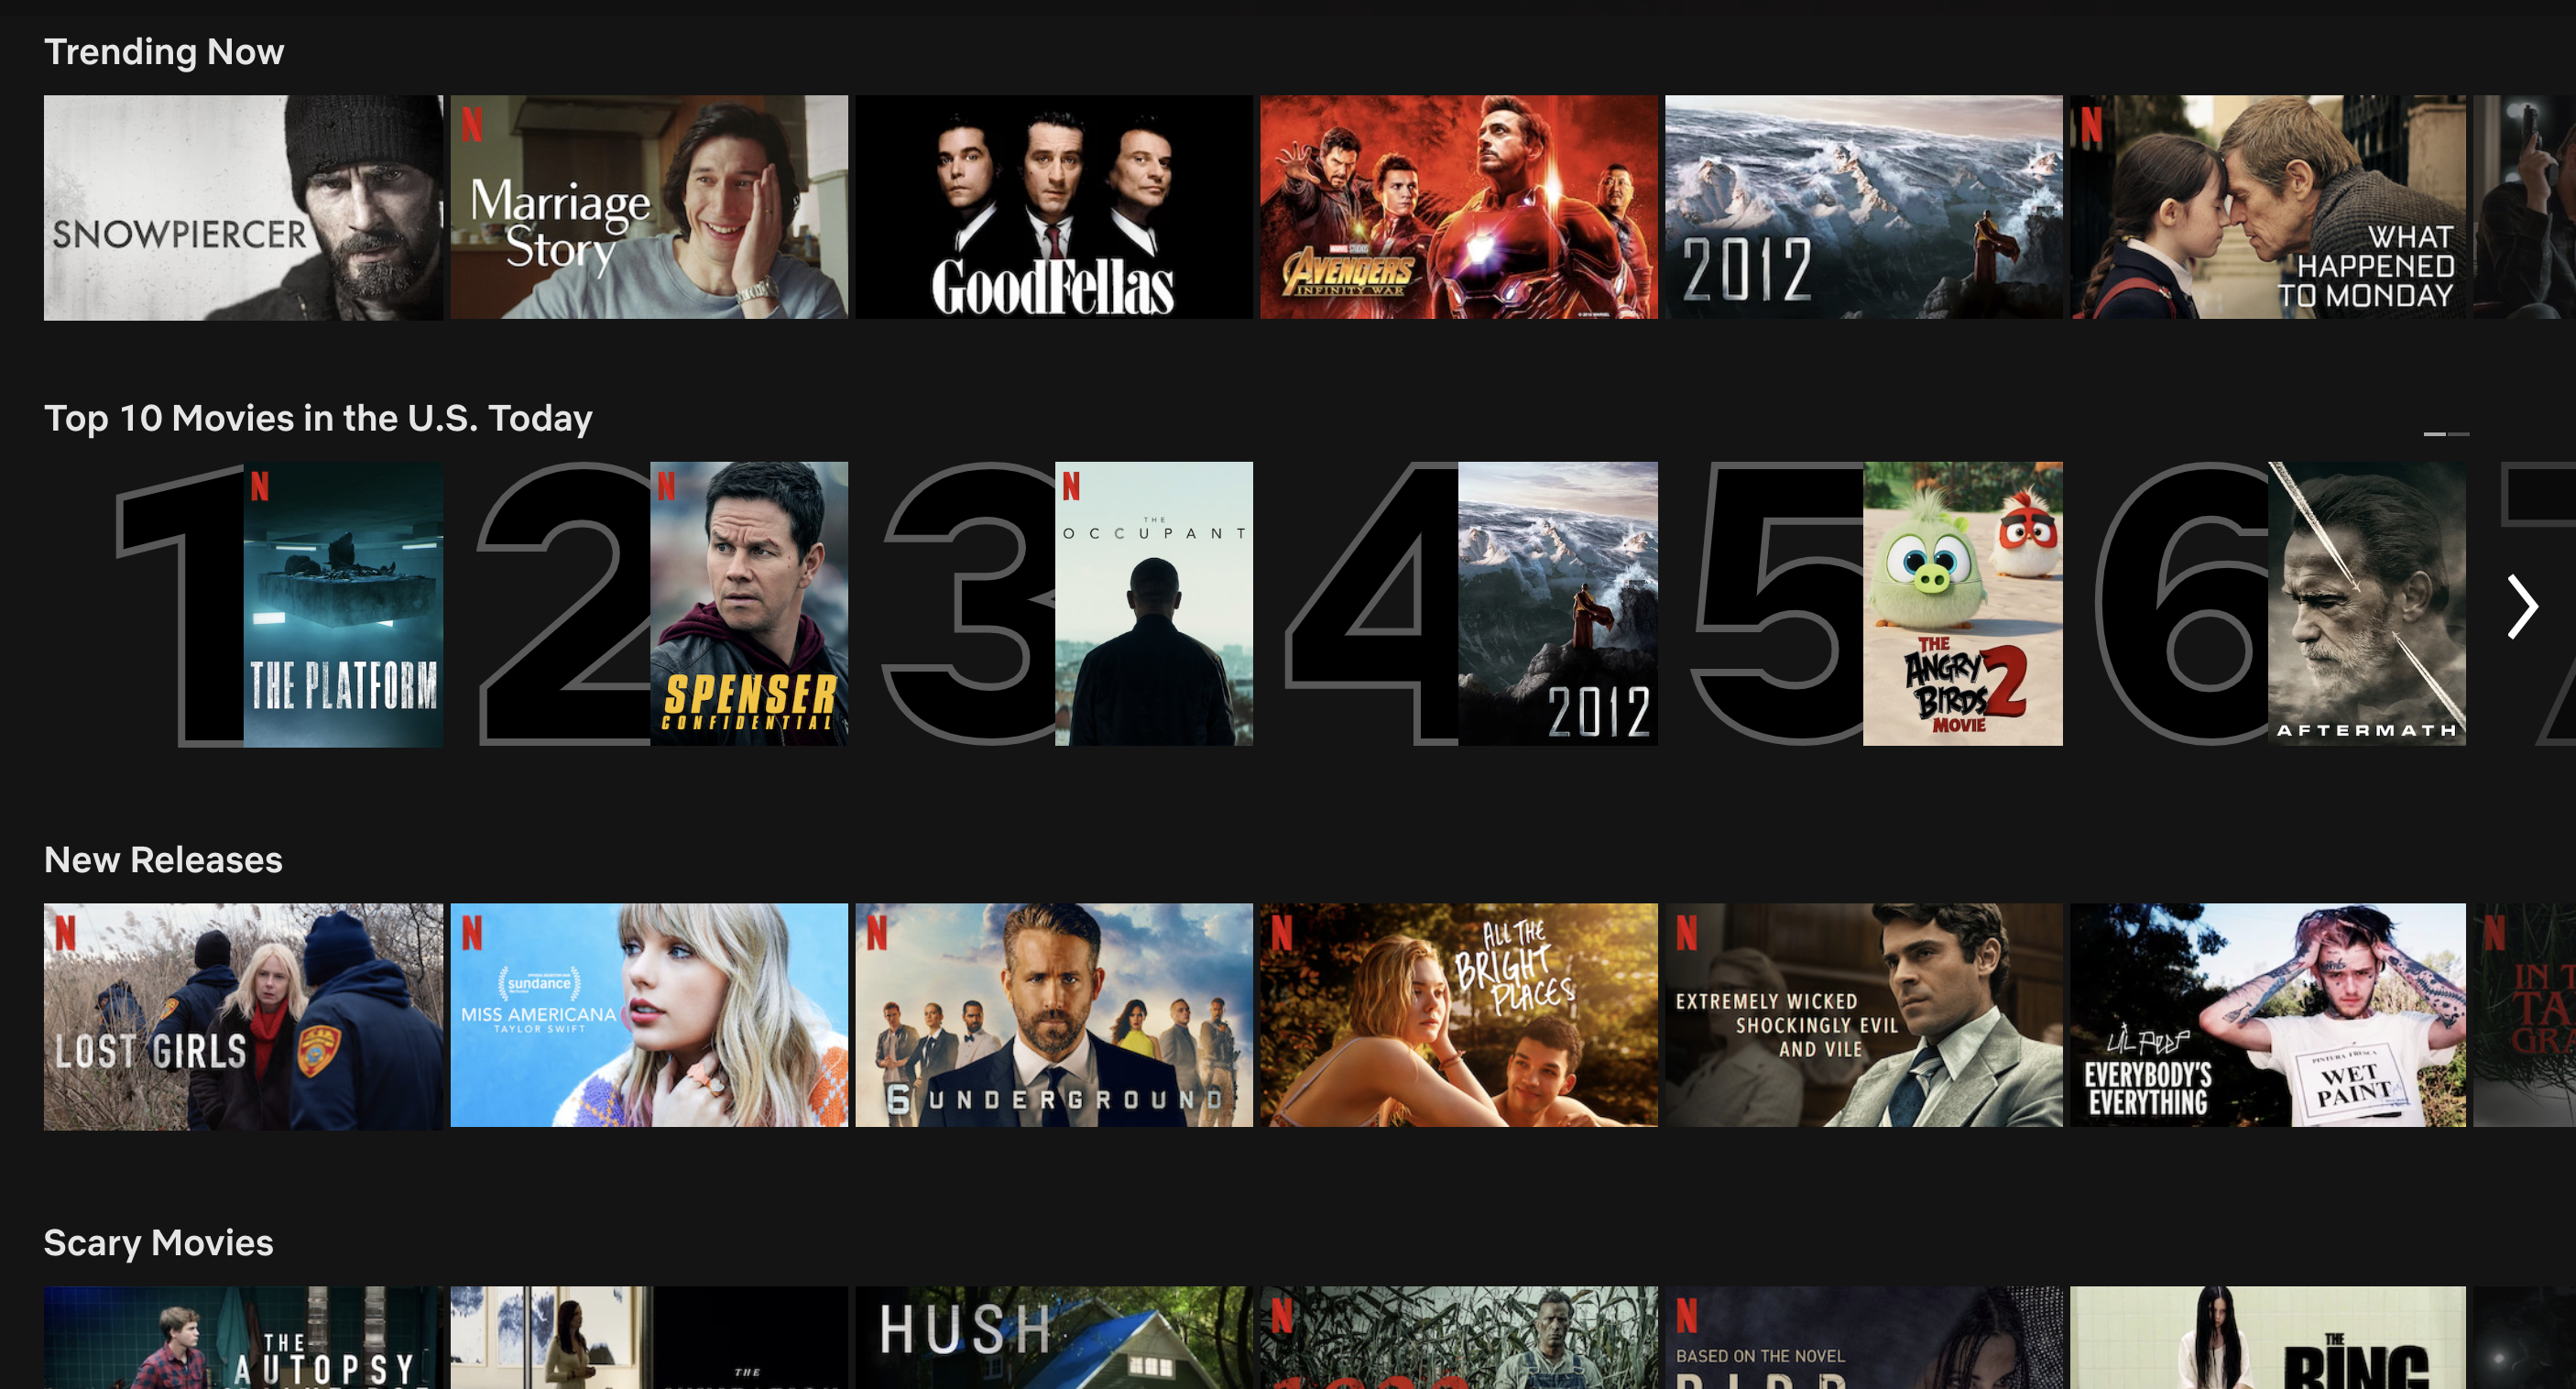

In [6]:
from IPython.display import Image
Image("/content/1_Fl8Iy2Td2Tp4GjztwVT45w.png")

In [ ]:
!pip install pyspark 

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 45.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=ba3d0e62691234aa60585428a5073b868852f25efbe511a5a4ffcf33d45067cb
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

In [ ]:
!kaggle datasets download -d shubhammehta21/movie-lens-small-latest-dataset

  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 65.2MB/s]


In [ ]:
!ls

gdrive	movie-lens-small-latest-dataset.zip  sample_data


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  movie-lens-small-latest-dataset.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


In [ ]:
import pyspark as ps
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf, col, when
import numpy as np


In [ ]:
spark = ps.sql.SparkSession.builder \
            .master("local") \
            .appName("Movie recommendation ") \
            .getOrCreate() 
            
sc = spark.sparkContext 
sqlContext = SQLContext(sc)

In [ ]:
ratings_df = spark.read.csv('/content/ratings.csv',header=True, inferSchema=True)
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [ ]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [ ]:
movies_df = spark.read.csv('/content/movies.csv',header=True, inferSchema=True) 
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
movies_df.show(1)

+-------+----------------+--------------------+
|movieId|           title|              genres|
+-------+----------------+--------------------+
|      1|Toy Story (1995)|Adventure|Animati...|
+-------+----------------+--------------------+
only showing top 1 row



In [ ]:
training_df, validation_df = ratings_df.randomSplit([.8, .2])

In [ ]:
iterations = 10
regularization_parameter = 0.1
rank= 4
errors = []
err = 0

In [ ]:
als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=4, userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(training_df)
predictions = model.transform(validation_df)
new_predictions = predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(new_predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8779684254517098


In [ ]:
als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=5, userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(training_df)
predictions = model.transform(validation_df)
new_predictions = predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(new_predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8767829888981732


In [ ]:
for rank in range(4,10):
    als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="userId", itemCol="movieId", ratingCol="rating")
    model = als.fit(training_df)
    predictions = model.transform(validation_df)
    new_predictions = predictions.filter(col('prediction') != np.nan)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(new_predictions)
    print("Rank :", rank, " Root-mean-square error = " + str(rmse))

Rank : 4  Root-mean-square error = 0.8779684254517098
Rank : 5  Root-mean-square error = 0.8767829888981732
Rank : 6  Root-mean-square error = 0.8793862975331244
Rank : 7  Root-mean-square error = 0.8795904781654198
Rank : 8  Root-mean-square error = 0.8751746024607806
Rank : 9  Root-mean-square error = 0.8808478269215414


In [ ]:
als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="userId", itemCol="movieId", ratingCol="rating")
paramGrid = ParamGridBuilder() \
    .addGrid(als.regParam, [0.1, 0.01, 0.18]) \
    .addGrid(als.rank, range(4, 6)) \
    .build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(training_df)

In [ ]:
cvModel_pred = cvModel.transform(validation_df)
cvModel_pred = cvModel_pred.filter(col('prediction') != np.nan)
rmse = evaluator.evaluate(cvModel_pred)
print("the rmse for optimal grid parameters with cross validation is: {}".format(rmse))

the rmse for optimal grid parameters with cross validation is: 0.8779684254517098


In [ ]:
final_als = ALS(maxIter=10, regParam=0.1, rank=4, userCol="userId", itemCol="movieId", ratingCol="rating")
final_model = final_als.fit(training_df)

In [ ]:
predictions = final_model.transform(validation_df)
predictions.show(n = 10)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|    91|    471|   1.0|1112713817| 2.9722624|
|   500|    471|   1.0|1005528017| 3.2916183|
|   520|    471|   5.0|1326609921| 3.6554563|
|   541|    471|   3.0| 835643551| 3.8872924|
|   599|    833|   1.5|1519330029| 1.3572986|
|   609|    833|   3.0| 847221080| 1.9135638|
|   608|    833|   0.5|1117506344|  1.959724|
|   606|   1088|   3.0|1171926956| 3.3356426|
|    64|   1088|   4.0|1161559902| 3.3947425|
|   489|   1088|   4.5|1332775009| 2.9336617|
+------+-------+------+----------+----------+
only showing top 10 rows



In [ ]:
predictions.join(movies_df, "movieId").select("userId","title","genres","prediction").show(5)

+------+--------------------+------+----------+
|userId|               title|genres|prediction|
+------+--------------------+------+----------+
|    91|Hudsucker Proxy, ...|Comedy| 2.9722624|
|   500|Hudsucker Proxy, ...|Comedy| 3.2916183|
|   520|Hudsucker Proxy, ...|Comedy| 3.6554563|
|   541|Hudsucker Proxy, ...|Comedy| 3.8872924|
|   599|High School High ...|Comedy| 1.3572986|
+------+--------------------+------+----------+
only showing top 5 rows



In [ ]:
links_df = spark.read.csv('/content/links.csv',header=True, inferSchema=True)
links_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [ ]:
for_one_user = predictions.filter(col("userId")==450).join(movies_df, "movieId").join(links_df,"movieId").select("userId","title","genres","tmdbId","prediction")
for_one_user.show(5)

+------+--------------------+--------------------+------+----------+
|userId|               title|              genres|tmdbId|prediction|
+------+--------------------+--------------------+------+----------+
|   450|Clockwork Orange,...|Crime|Drama|Sci-F...|   185| 3.9999244|
|   450| Patriot, The (2000)|    Action|Drama|War|  2024| 3.7717814|
|   450|Time Machine, The...|Action|Adventure|...|  2134| 4.2522187|
|   450|Boogie Nights (1997)|               Drama|  4995| 4.2506247|
|   450|Mission to Mars (...|              Sci-Fi|  2067| 2.7895403|
+------+--------------------+--------------------+------+----------+
only showing top 5 rows



In [ ]:
import webbrowser
link="https://www.themoviedb.org/movie/"
for movie in for_one_user.take(3):
  movieURL=link+str(movie.tmdbId)
  print(movie.title)
  print(movie.tmdbId)
  webbrowser.open(movieURL)

Clockwork Orange, A (1971)
185
Patriot, The (2000)
2024
Time Machine, The (1960)
2134


In [ ]:
# Generate top 5 movies recommendations for each user
userRecomments = final_model.recommendForAllUsers(5)
# Generate top 5 user recommendations for each movie
movieRecomments = final_model.recommendForAllItems(5)

In [ ]:
userRecomments.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
userRecomments.select("userId","recommendations.movieId").show(10, False)

+------+-----------------------------------+
|userId|movieId                            |
+------+-----------------------------------+
|471   |[8477, 148881, 6461, 40491, 6818]  |
|463   |[26171, 141718, 68945, 3379, 6732] |
|496   |[32582, 68945, 3379, 2899, 3567]   |
|148   |[7842, 141718, 51931, 84847, 59018]|
|540   |[141718, 26171, 68945, 3379, 7842] |
|392   |[3567, 141718, 89759, 32582, 5292] |
|243   |[26171, 5466, 2899, 4821, 86377]   |
|31    |[26171, 87234, 5466, 7842, 6732]   |
|516   |[7842, 25947, 87234, 60943, 59018] |
|580   |[26171, 141718, 2899, 4821, 3182]  |
+------+-----------------------------------+
only showing top 10 rows



In [ ]:
movieRecomments.select("movieId","recommendations.userId").show(10, False)

+-------+-------------------------+
|movieId|userId                   |
+-------+-------------------------+
|1580   |[53, 578, 543, 243, 276] |
|4900   |[53, 147, 537, 258, 55]  |
|5300   |[154, 360, 595, 296, 53] |
|6620   |[154, 461, 295, 258, 375]|
|7340   |[543, 544, 53, 12, 578]  |
|32460  |[360, 154, 393, 259, 98] |
|54190  |[53, 543, 388, 544, 236] |
|471    |[360, 154, 250, 40, 20]  |
|1591   |[53, 236, 55, 549, 576]  |
|140541 |[55, 207, 147, 549, 3]   |
+-------+-------------------------+
only showing top 10 rows



In [ ]:
# Generate top 10 Book recommendations for a specified set of users
users = ratings_df.select("userId").distinct().limit(3);
users.show()

+------+
|userId|
+------+
|   148|
|   463|
|   471|
+------+



In [ ]:
userSubsetRecs = model.recommendForUserSubset(users, 10)